In [1]:
#!pip install opencv-python
#!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y
#!pip install mediapipe

In [2]:
#!pip install opencv-python transformers accelerate


In [3]:
import time
t = str(int(time.time()))+"_"
t

'1728496051_'

In [4]:
from diffusers import AutoencoderKL, StableDiffusionXLControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers import DDIMScheduler, EulerAncestralDiscreteScheduler
from controlnet_aux import MidasDetector

from PIL import Image
import torch
import random
import numpy as np
import cv2

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.3.1+cu121)
    Python  3.11.6 (you have 3.11.4)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/root/miniconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-10-09 17:47:43.335775: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] 

/root/miniconda3/lib/python3.11/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


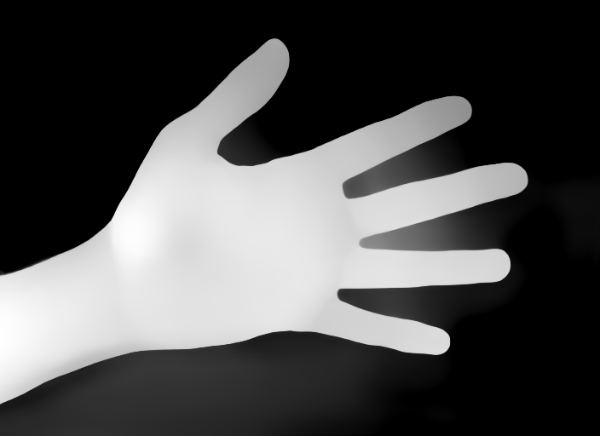

In [5]:
img = cv2.imread("./test3.jpg")
processor_midas = MidasDetector.from_pretrained("lllyasviel/Annotators", cache_dir='./modele cache/')

controlnet_img = processor_midas(img, output_type='cv2')

height, width, _  = controlnet_img.shape
ratio = np.sqrt(512. * 512. / (width * height))
new_width, new_height = int(width * ratio), int(height * ratio)
controlnet_img = cv2.resize(controlnet_img, (new_width, new_height))
controlnet_img = Image.fromarray(controlnet_img)

controlnet_img.save("./img/"+t+"controlnet.jpg")

controlnet_img

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch modele cache/models--RunDiffusion--Juggernaut-X-v10/snapshots/612dfaa62fd6efc9af763d2badc01d699a6feae5/unet: Error no file named diffusion_pytorch_model.safetensors found in directory modele cache/models--RunDiffusion--Juggernaut-X-v10/snapshots/612dfaa62fd6efc9af763d2badc01d699a6feae5/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

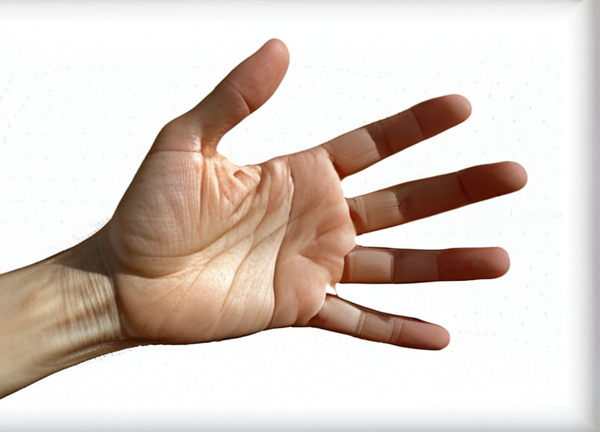

In [6]:
controlnet_conditioning_scale = 1.0  
prompt = "A detailed, high-quality photograph of a human palm on a pure white background. The palm is facing the viewer, fingers extended, with the pattern of creases and lines on the hand clearly visible. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry, tattoos, text, watermarks, multiple hands, gloves, nail polish, distracting details."



controlnet = ControlNetModel.from_pretrained(
    "xinsir/controlnet-depth-sdxl-1.0",
    torch_dtype=torch.float16, cache_dir='./modele cache/'
)

# when test with other base model, you need to change the vae also.
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir='./modele cache/')

eulera_scheduler = EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="scheduler",cache_dir='./modele cache/')


pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "RunDiffusion/Juggernaut-X-v10",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
    scheduler=eulera_scheduler,
    cache_dir='./modele cache/'
).to("cuda")



images = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image=controlnet_img,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    width=new_width,
    height=new_height,
    num_inference_steps=50,
    ).images

images[0].save("./img/"+t+"image_0.jpg")
images[0]

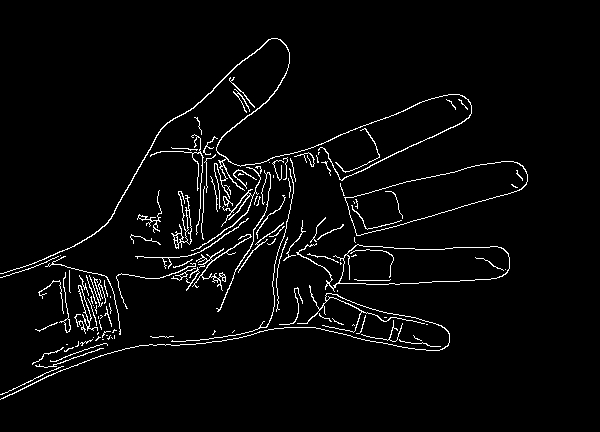

In [7]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# Load the image
image = cv2.imread("./img/"+t+"image_0.jpg", cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred_image, threshold1=7, threshold2=80)

canny_image=Image.fromarray(edges)
canny_image.save("./img/"+t+"canny_image.jpg")
canny_image

In [8]:
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image

# initialize the models and pipeline
controlnet_conditioning_scale = 0.5  # recommended for good generalization
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16, cache_dir='./modele cache/'
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "RunDiffusion/Juggernaut-X-v10", controlnet=controlnet,
    vae=vae, torch_dtype=torch.float16, cache_dir='./modele cache/'

)
pipe.enable_model_cpu_offload()



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch modele cache/models--RunDiffusion--Juggernaut-X-v10/snapshots/612dfaa62fd6efc9af763d2badc01d699a6feae5/unet: Error no file named diffusion_pytorch_model.safetensors found in directory modele cache/models--RunDiffusion--Juggernaut-X-v10/snapshots/612dfaa62fd6efc9af763d2badc01d699a6feae5/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

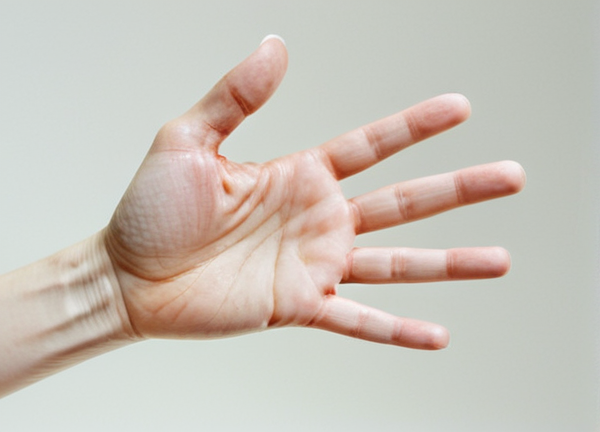

In [9]:
prompt = "A detailed, high-quality photograph of a human palm on a pure white background. White background.The palm is facing the viewer, fingers extended, with the pattern of creases and lines on the hand clearly visible. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry, tattoos, text, watermarks, multiple hands, gloves, nail polish, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_"+str(im)+".jpg")

images_g.images[0]

In [ ]:
#man
prompt = "A detailed, high-quality photograph of a man's hand on a pure white background. The hand is strong and masculine, with prominent veins and defined muscles. The fingers are slightly relaxed, showcasing the natural creases and lines of the hand. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry (unless desired), tattoos (unless desired), text, watermarks, multiple hands, gloves, smooth or overly soft skin, feminine features, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_man_"+str(im)+".jpg")

images_g.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#child
prompt = "A detailed, high-quality photograph of a child's hand on a pure white background. The hand is small and delicate, with smooth skin and subtle creases. Fingers are gently curved, showcasing the natural patterns of a young hand. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry, tattoos, text, watermarks, multiple hands, gloves, nail polish, rough skin, adult features, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_child_"+str(im)+".jpg")

images_g.images[0]

In [ ]:
#female
prompt = "]A detailed, high-quality photograph of a female hand on a pure white background. The hand is elegant with slender fingers, well-manicured nails, and smooth skin. The natural creases and lines of the hand are clearly visible. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry (unless desired), tattoos, text, watermarks, multiple hands, gloves, rough skin, unkempt nails, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_female_"+str(im)+".jpg")

images_g.images[0]

In [ ]:
#Old
prompt = "A detailed, high-quality photograph of an elderly person's hand on a pure white background. The hand shows signs of aging with prominent wrinkles, age spots, and veins. The texture and patterns of the skin are clearly visible. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry, tattoos, text, watermarks, multiple hands, gloves, smooth skin, youthful features, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_Old_"+str(im)+".jpg")

images_g.images[0]

In [ ]:
#Dirty
prompt = "A detailed, high-quality photograph of a dirty hand on a pure white background. The hand is visibly soiled with dirt or grime, showing textures and stains. The creases and lines of the hand are clearly visible despite the dirt. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry, tattoos, text, watermarks, multiple hands, gloves, clean skin, minimal dirt, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_Dirty_"+str(im)+".jpg")

images_g.images[0]

In [ ]:
#Oil
prompt = "A detailed, high-quality photograph of human hands stained with oil on a pure white background. The hands show visible oil smudges and textures, highlighting the greasy appearance and shine from the oil. The natural creases and lines of the hands are clearly visible despite the oil stains. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry, tattoos, text, watermarks, multiple pairs of hands, gloves, clean hands without oil stains, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_Oil_"+str(im)+".jpg")

images_g.images[0]

In [ ]:
#tattoo
prompt = "A detailed, high-quality photograph of a hand with a tattoo on a pure white background. The tattoo design on the skin is clearly visible and intricately detailed. The hand is positioned to showcase the tattoo, with fingers slightly relaxed. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry, additional tattoos (unless desired), text, watermarks, multiple hands, gloves, clean skin without tattoo, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_tattoo_"+str(im)+".jpg")

images_g.images[0]

In [ ]:
#African
prompt = "A detailed, high-quality photograph of an African American person's hands on a pure white background. The hands showcase natural skin tones and textures, with visible creases and lines. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry (unless desired), tattoos (unless desired), text, watermarks, multiple pairs of hands, gloves, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_African_"+str(im)+".jpg")

images_g.images[0]

In [ ]:
#Asian
prompt = "A detailed, high-quality photograph of an Asian person's hands on a pure white background. The hands exhibit smooth skin with natural creases and lines, accurately representing Asian skin tones and textures. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, jewelry (unless desired), tattoos (unless desired), text, watermarks, multiple pairs of hands, gloves, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_Asian_"+str(im)+".jpg")

images_g.images[0]

In [ ]:
#rings
prompt = "A detailed, high-quality photograph of hands adorned with multiple rings on a pure white background. The rings are stylish and prominent, highlighting the details of the jewelry. The natural creases and lines of the hands are clearly visible. There are no other objects or elements in the image."
negative_prompt = "Blurriness, low resolution, other body parts, extraneous objects, background elements, excessive jewelry not specified, tattoos (unless desired), text, watermarks, multiple pairs of hands, gloves, clean hands without rings, distracting details."


images_g = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image,
    num_images_per_prompt=10
)

for im in range(len(images_g.images)):
    images_g.images[im].save("./img/"+t+"image_rings_"+str(im)+".jpg")

images_g.images[0]